<a href="https://colab.research.google.com/github/hkaragah/risk_reliability/blob/main/PSHA_One_Rupture_Boore1997GMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PSHA: One Rupture Scenario Using Boore et al. 1997 GMM

## 1. Setting-up Working Directory

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

working_dir = "/content/drive/MyDrive/Colab Notebooks/risk_reliability"
if not os.path.exists(working_dir):
  os.makedirs(working_dir)
os.chdir(working_dir)

print("Current working directory:", os.getcwd())

Current working directory: /content/drive/MyDrive/Colab Notebooks/risk_reliability


In [3]:
!pwd

/content/drive/MyDrive/Colab Notebooks/risk_reliability


In [4]:
!ls

 BART.ipynb			 'Monte Carlo Simulation-Roulette Simulator.ipynb'
 Boore_et_al_1997.csv		 'Monte Carlo: Tests.ipynb'
 Boore_et_al_1997.gsheet	 'Prior and Posterior.ipynb'
'Kolmogorov-Smirnov test.ipynb'  'PSHA-Boore1997 GMM.ipynb'
'Monte Carlo_Resampling.ipynb'


## 2. Boore et al. (1997) Ground-Motion Model (GMM)

1- __Reference__

David M. Boore, William B. Joyner, and Thomas E. Fumal, 1997, Equations for Estimating Horizontal Response Spectra and Peak Acceleration from Western North American Earethquakes: A Summary of recent Work, Seismological Research Letters, Vol. 68, No. 1, 128-153.

2- __Estimated physical parameter__

  - Peak ground acceleration (Horizontal)
  - Spectral acceleration (h=5%, T=0.1 to 2 sec) (Horizontal)



3- __Used strong motion data__

  - Area: Western North America
  - Type of earthquake: Shallow earthquake (which the fault rupture lies mainly above a depth of  20km)
  - Period: 1940 – 1992 years
  - Number of events: 19
  - Number of records: 271
  - Magnitude: 5.2 – 7.4
  - Epicentral distance: 0 – 118 km

4- __Style of faulting__

  - Strike-slip
  - Reverse-slip
  - Mechanism is not specified

5- __Ground condition__

Classified by the average S-wave velocity over 30 m from ground surface

6- __Definition of magnitude__

Moment magnitude

7- __Definition of source distance__

Closest horizontal distance to a point on the earth's surface that lies directly above the rupture.

8- __Definition of horizontal component__

Random horizontal component

9- __Applicability written in the paper__

The equations are to be used magnitude 5.5 - 7.5 and distance no greater than 80 km.

10- __Empirical attenuation formula__

$$\ln Y = b_1 + b_2(M-6) + b_3(M-6)^2 + b_5 \ln r + b_V \ln \frac{V_S}{V_A}$$

* $r=\sqrt{r_{jb}^2 + h^2}$

* $b_1 =
\begin{cases}
b_{1SS} &\text{for strike-slip earquake s}\\
b_{1RV} &\text{for reverse-slip earthquake s}\\
b_{1ALL} &\text{if mechanism not specified}
\end{cases}$

* $Y$: peak horizontal acceleration or pseudo acceleration response (g)

* $M$: moment magnitude

* $r_{jb}$: closest horizontal distance to the surface projection of the rupture plane (km)

* $V_S$: average shear wave velocity to 30 m (m/sec)

Standard Error:
* $\sigma_{\ln Y}^2 = \sigma_Y^2 + \sigma_e^2$
* $\sigma_{\ln Y}$: one-sigma value of the natural logarithm of the ground-motion value
* $\sigma_e^2$: earthquake-to-earthquake component of variability
* $\sigma_r^2$: all other components of variability
* $\sigma_r^2 = \sigma_1^2 + \sigma_c^2$
* $\sigma_1^2$: variance from the first stage of regression
* $\sigma_c^2$: correction needed to give the variance corresponding to the randomly-oriented horizontal component

<a href="https://iisee.kenken.go.jp/eqflow/reference/1_2.htm">Boore et al 1997 coefficients</a>

In [53]:
import pandas as pd

# Boore et al. 1997 coefficients
boore = pd.read_csv("Boore_et_al_1997.csv", header=0, index_col="Period")
boore.drop([0],axis=0,inplace=True)
boore.head()

,B1SS,B1RV,B1ALL,B2,B3,B5,BV,VA,h,s1,sc,sr,se,slnY
Period,,,,,,,,,,,,,,
0.10,1.006,1.087,1.059,0.753,-0.226,-0.934,-0.212,1112,6.27,0.440,0.189,0.479,0.0,0.479
0.11,1.072,1.164,1.130,0.732,-0.230,-0.937,-0.211,1291,6.65,0.437,0.200,0.481,0.0,0.481
0.12,1.109,1.215,1.174,0.721,-0.233,-0.939,-0.215,1452,6.91,0.437,0.210,0.485,0.0,0.485
0.13,1.128,1.246,1.200,0.711,-0.233,-0.939,-0.221,1596,7.08,0.435,0.216,0.486,0.0,0.486
0.14,1.135,1.261,1.208,0.707,-0.230,-0.938,-0.228,1718,7.18,0.435,0.223,0.489,0.0,0.489


## 3. Computing Median and Standard Deviation of Spectral Acceleration

In [37]:
from math import sqrt, log, exp
import numpy as np

def compute_median_ground_motion(magnitude, dist_km, velocity_m_per_sec):

    M = magnitude
    r_jb = dist_km
    V_S = velocity_m_per_sec

    r = np.sqrt(r_jb**2 + boore['h']**2)

    b2 = boore['B2']
    b3 = boore['B3']
    b5 = boore['B5']
    bv = boore['BV']
    V_A = boore['VA']

    boore['YSS'] = np.exp(boore['B1SS'] + b2*(M-6) + b3*(M-6)**2 + b5*np.log(r) + bv*np.log(V_S/V_A))
    boore['YRV'] = np.exp(boore['B1RV'] + b2*(M-6) + b3*(M-6)**2 + b5*np.log(r) + bv*np.log(V_S/V_A))
    boore['YALL'] = np.exp(boore['B1ALL'] + b2*(M-6) + b3*(M-6)**2 + b5*np.log(r) + bv*np.log(V_S/V_A))

One rupture scenario is defined as a single strike-slip fault that produces only M=6.5 earthquakes at a rate of 0.01 per year:

* $M=6.5$
* $\lambda=0.01$

The site is located at 10 km from the fault and has average shear wave velocity of 500 m/s over a depth of 30 meters:

* $R=10 \ km$
* $V_{S,30}=500 \ m/s$

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [81]:
M = 6.5
r_jb = 10 # km
V_S = 500 # m/sec
annual_rate = 0.01

In [55]:
compute_median_ground_motion(M, r_jb, V_S)
boore.head()

,B1SS,B1RV,B1ALL,B2,B3,B5,BV,VA,h,s1,sc,sr,se,slnY,YSS,YRV,YALL
Period,,,,,,,,,,,,,,,,,
0.10,1.006,1.087,1.059,0.753,-0.226,-0.934,-0.212,1112,6.27,0.440,0.189,0.479,0.0,0.479,0.444860,0.482393,0.469073
0.11,1.072,1.164,1.130,0.732,-0.230,-0.937,-0.211,1291,6.65,0.437,0.200,0.481,0.0,0.481,0.473107,0.518698,0.501359
0.12,1.109,1.215,1.174,0.721,-0.233,-0.939,-0.215,1452,6.91,0.437,0.210,0.485,0.0,0.485,0.494142,0.549398,0.527328
0.13,1.128,1.246,1.200,0.711,-0.233,-0.939,-0.221,1596,7.08,0.435,0.216,0.486,0.0,0.486,0.511128,0.575144,0.549286
0.14,1.135,1.261,1.208,0.707,-0.230,-0.938,-0.228,1718,7.18,0.435,0.223,0.489,0.0,0.489,0.526031,0.596668,0.565868


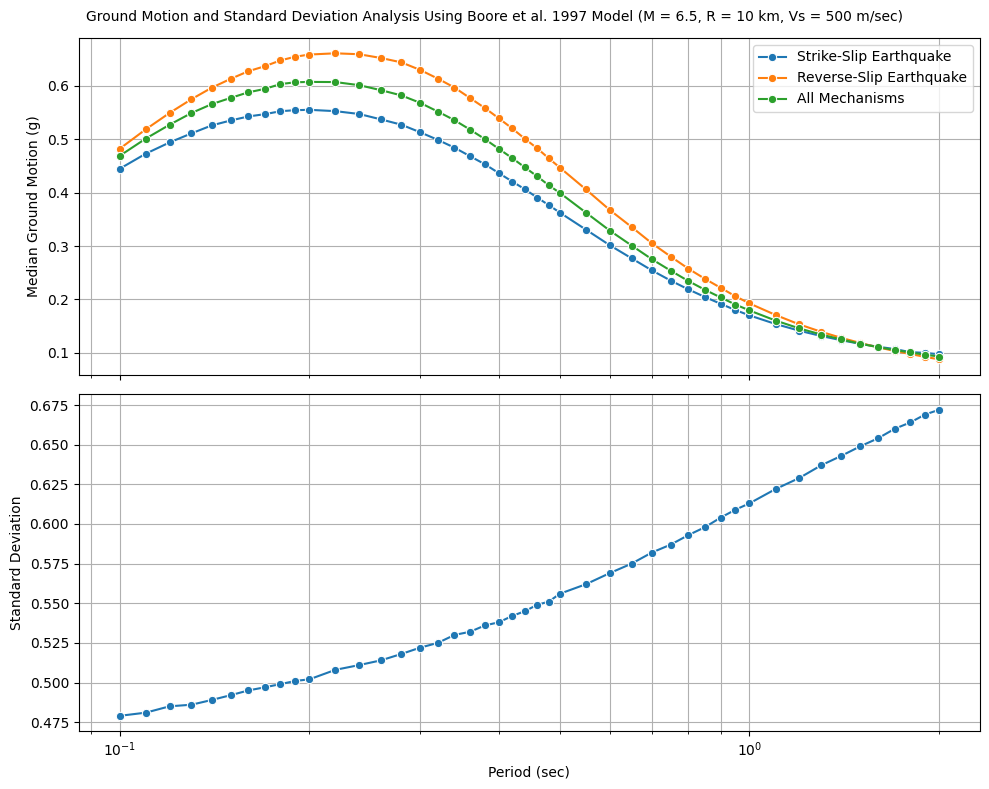

In [77]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10,8))

boore_melted = pd.melt(boore.reset_index(), id_vars=['Period'], value_vars=['YSS', 'YRV', 'YALL'],
                       var_name='Variable', value_name='Median Ground Motion (g)')

label_mapping = {
    'YSS': 'Strike-Slip Earthquake',
    'YRV': 'Reverse-Slip Earthquake',
    'YALL': 'All Mechanisms'
}

sns.lineplot(data=boore_melted, x='Period', y='Median Ground Motion (g)', hue='Variable', marker='o', hue_order=['YSS', 'YRV', 'YALL'], ax=ax[0])
ax[0].set_xscale('log')
ax[0].set_xlabel('Period (sec)')
ax[0].set_ylabel('Median Ground Motion (g)')
ax[0].grid(which='both')

# Customizing legend labels
handles, labels = ax[0].get_legend_handles_labels()  # Get the handles and labels
new_labels = [label_mapping[label] for label in labels]  # Map to new labels
ax[0].legend(handles, new_labels, title='', loc='best')  # Update legend

sns.lineplot(data=boore, x=boore.index, y='slnY', marker='o', ax=ax[1])
ax[1].set_xscale('log')
ax[1].set_xlabel('Period (sec)')
ax[1].set_ylabel('Standard Deviation')
ax[1].grid(which='both')

fig.suptitle('Ground Motion and Standard Deviation Analysis Using Boore et al. 1997 Model (M = 6.5, R = 10 km, Vs = 500 m/sec)', fontsize=10)
plt.tight_layout()
plt.show()

## 4. Computing Annual Rate of Exceedance for SA(1s)

In [78]:
from scipy.stats import norm

In [119]:
spectral_acceleration = np.linspace(5e-2, 1, 20) # Specteral Acceleration SA(1 s) [g]
period = 1.0 # sec

probability_of_exceedance = 1 - norm.cdf(np.log(spectral_acceleration), loc=np.log(boore.loc[period, 'YSS']), scale=boore.loc[period, 'slnY'])
annual_rate_of_exceedance = annual_rate * probability_of_exceedance

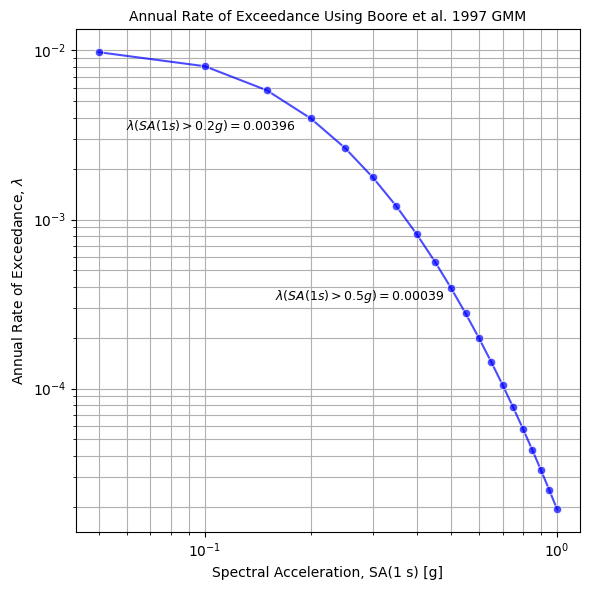

In [124]:
plt.figure(figsize=(6, 6))
sns.lineplot(x=spectral_acceleration, y=annual_rate_of_exceedance, marker='o', alpha=0.7, linestyle='-', color='b')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Spectral Acceleration, SA(1 s) [g]')
plt.ylabel('Annual Rate of Exceedance, $\lambda$')
plt.title('Annual Rate of Exceedance Using Boore et al. 1997 GMM', fontsize=10)

target_sa = 0.2 # g
index = np.abs(spectral_acceleration - target_sa).argmin() # Index of closest value to target_Sa
annual_rate_for_target_sa = annual_rate_of_exceedance[index] # Retrieve corresponding value from annual_rate_of_exceedance
plt.annotate(fr"$\lambda (SA(1s)>{target_sa}g) = {annual_rate_for_target_sa:.5f}$",
             xy=(target_sa-2e-2, annual_rate_for_target_sa), xycoords='data', va='top', ha='right', fontsize=9)

target_sa = 0.5 # g
index = np.abs(spectral_acceleration - target_sa).argmin() # Index of closest value to target_Sa
annual_rate_for_target_sa = annual_rate_of_exceedance[index] # Retrieve corresponding value from annual_rate_of_exceedance
plt.annotate(fr"$\lambda (SA(1s)>{target_sa}g) = {annual_rate_for_target_sa:.5f}$",
             xy=(target_sa-2e-2, annual_rate_for_target_sa), xycoords='data', va='top', ha='right', fontsize=9)

plt.grid(which='both')
plt.tight_layout()
plt.show()